In [88]:
import numpy as np
import pandas as pd
import pymovements as pm
from scipy import interpolate
from tqdm import tqdm
import math
from matplotlib import pyplot as plt

from sp_eyegan.preprocessing import data_loader as data_loader
from sp_eyegan.preprocessing import event_detection as event_detection
from sp_eyegan.preprocessing import smoothing as smoothing

In [89]:
gaze_data_list, gaze_feature_dict, gaze_label_matrix, gaze_label_dict = data_loader.load_ehtask_data(
        ehtask_dir='../data/tmp/', # just contains a single file
        target_sampling_rate=1000,
        sampling_rate=100,
    )

100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


In [90]:
gdl = np.array(gaze_data_list)
gdl.shape

(1, 14997, 6)

In [91]:
x_dva = gaze_data_list[0][:, gaze_feature_dict['x_dva_left']]
y_dva = gaze_data_list[0][:, gaze_feature_dict['y_dva_left']]

In [70]:
x_dva.shape

(14997,)

In [71]:
x_dva

array([1.47255904, 1.47255904, 1.47255904, ..., 5.87089982, 5.87089982,
       5.87089982])

In [72]:
y_dva

array([0.        , 0.        , 0.        , ..., 1.63609223, 1.63609223,
       1.63609223])

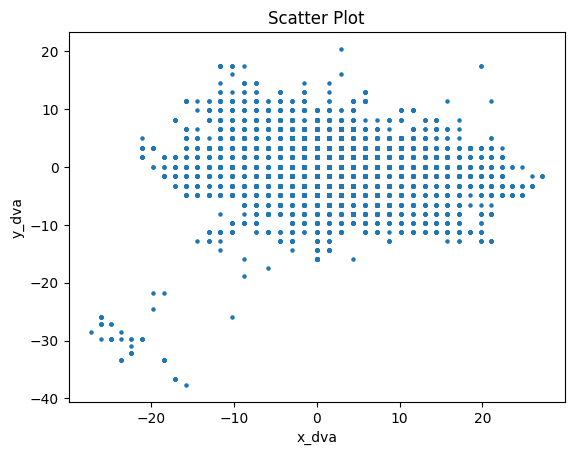

In [18]:
plt.scatter(x_dva, y_dva, marker='o', s=5)  # Adjust the marker and size as needed

plt.xlabel('x_dva')
plt.ylabel('y_dva')
plt.title('Scatter Plot')

plt.show()

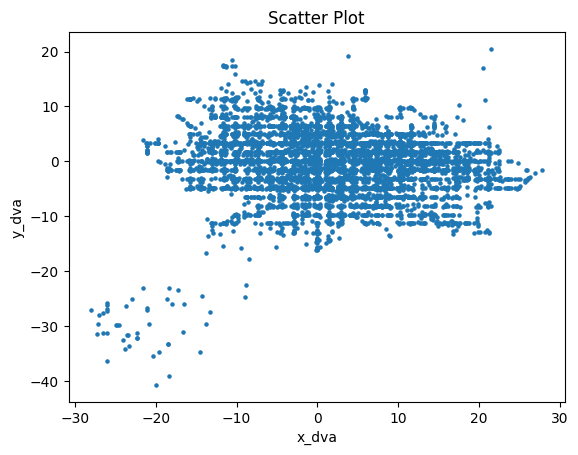

In [19]:
smoothing_window_length = 0.007
target_sampling_rate = 100
smooth_vals = smoothing.smooth_data(x_dva, y_dva,
                                            n=2, smoothing_window_length=smoothing_window_length,
                                            sampling_rate=target_sampling_rate)

x_smo = smooth_vals['x_smo']
y_smo = smooth_vals['y_smo']

plt.scatter(x_smo, y_smo, marker='o', s=5)  # Adjust the marker and size as needed

plt.xlabel('x_dva')
plt.ylabel('y_dva')
plt.title('Scatter Plot')

plt.show()

In [73]:
x_smo.shape

(14997,)

In [74]:
# dispersion
min_fixation_length = 100
max_fixation_dispersion = 2.7

list_dicts, event_df = event_detection.get_sacc_fix_lists_dispersion(
    x_smo, y_smo,
    corrupt=None,
    sampling_rate=target_sampling_rate,
    min_duration=min_fixation_length,
    velocity_threshold=20,
    flag_skipNaNs=False,
    verbose=0,
    max_fixation_dispersion=max_fixation_dispersion,
)

In [75]:
event_df
# event_df[event_df['event'] == 1]
#  fix=1, saccade=2, corrupt=3

,x_deg,y_deg,sac,corrupt,event
0,-0.126219,0.000000,0.0,False,1
1,0.378658,0.000000,0.0,False,1
2,1.093901,0.000000,0.0,False,1
3,1.598778,0.000000,0.0,False,1
4,1.472559,0.000000,0.0,False,1
...,...,...,...,...,...
14992,6.950538,1.636092,0.0,False,1
14993,6.244621,1.636092,0.0,False,1
14994,5.746326,1.636092,1.0,False,2
14995,5.870900,1.636092,1.0,False,2


In [78]:
fixations = list_dicts['fixations']
fixation_list = []
for f_i in range(len(fixations)):
    fixation_list.append(np.concatenate([
        np.expand_dims(x_smo[fixations[f_i]], axis=1),
        np.expand_dims(y_smo[fixations[f_i]], axis=1),
        # np.expand_dims(x_pixel[fixations[f_i]], axis=1),
        # np.expand_dims(y_pixel[fixations[f_i]], axis=1),
        # np.expand_dims(vel_x[fixations[f_i]], axis=1) / target_sampling_rate,
        # np.expand_dims(vel_y[fixations[f_i]], axis=1) / target_sampling_rate,
    ], axis=1))
print('number of fixations: ' + str(len(fixation_list)))

number of fixations: 483


In [79]:
fixation_list[0][:, 0]

array([-0.12621935,  0.37865804,  1.093901  ,  1.59877839,  1.47255904,
        1.47255904,  1.47255904,  1.47255904,  1.47255904,  1.47255904,
        1.47255904,  1.47255904,  1.47255904,  1.47255904,  1.47255904,
        1.47255904,  1.47255904,  1.47255904,  1.47255904,  1.47255904,
        1.47255904,  1.47255904,  1.47255904,  1.47255904,  1.47255904,
        1.47255904,  1.47255904,  1.47255904,  1.59877839,  1.093901  ,
        0.37865804, -0.12621935,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [80]:
filtered_fixation_list = []
mx_dispersion = 0.0
mn_len_x_dva = 10000
fix_window_size = 100
window_sizes = []
for f_i in tqdm(np.arange(len(fixation_list))):
    cur_x_dva = fixation_list[f_i][:, 0]
    cur_y_dva = fixation_list[f_i][:, 1]
    x_amp = np.abs(np.max(cur_x_dva) - np.min(cur_x_dva))
    y_amp = np.abs(np.max(cur_y_dva) - np.min(cur_y_dva))
    cur_dispersion = x_amp + y_amp
    mn_len_x_dva = min(mn_len_x_dva, len(cur_x_dva))
    mx_dispersion = max(mx_dispersion, cur_dispersion)
    if cur_dispersion >= max_fixation_dispersion:
        print(f"cur_dispersion: {cur_dispersion}")
        continue
    window_sizes.append(len(cur_x_dva))
    if len(cur_x_dva) <= fix_window_size:
        # print(f"len(cur_x_dva): {len(cur_x_dva)}")
        continue
    filtered_fixation_list.append(fixation_list[f_i])
print('number of fixations after filtering: ' + str(len(filtered_fixation_list)))
print(f"mx_dispersion: {mx_dispersion}")
print(f"mn_len_x_dva: {mn_len_x_dva}")

100%|██████████| 483/483 [00:00<00:00, 43438.66it/s]

number of fixations after filtering: 10
mx_dispersion: 1.9998718350966793
mn_len_x_dva: 1


In [81]:
window_sizes = np.array(window_sizes)
window_sizes.shape

(483,)

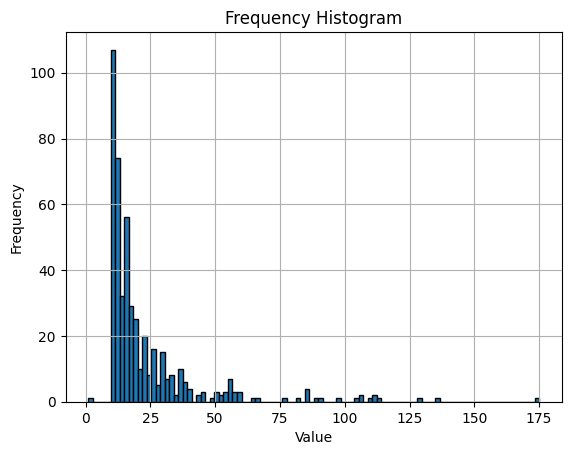

In [82]:
plt.hist(window_sizes, bins=100, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
plt.grid(True)

plt.show()

In [68]:
int(np.floor((1000 / 1000.) * 100))

100